# Projeto de Previsão de Acidente Vascular Cerebral (AVC) com Python
Este notebook realiza a análise completa para a construção e avaliação de um modelo preditivo de AVC, seguindo a rubrica de Machine Learning para a área da saúde.

# Tarefa Um: Importação de dados e pré-processamento de dados
O objetivo é limpar os dados, tratar os valores ausentes e entender as relações entre as variáveis.

## 1 - Carregar dados e instalar pacotes

In [87]:
# Importação das bibliotecas essenciais para Ciência de Dados em Python

# Pandas: A biblioteca principal para carregar, manipular e limpar dados (nosso 'tidyverse' do Python)
import pandas as pd 
# NumPy: Usado para operações numéricas e arrays
import numpy as np 
# Matplotlib/Seaborn: Usados para visualização de dados (criação de gráficos). Seaborn é ótimo para estatística.
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn: É a biblioteca padrão para Machine Learning em Python
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE 
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Define o caminho do arquivo
file_path = '../data/healthcare-dataset-stroke-data.csv'

# Lê o arquivo CSV para um DataFrame do Pandas (df)
df = pd.read_csv(file_path)

# Mostra as primeiras 5 linhas para verificar se o carregamento funcionou
print("--- Primeiras 5 linhas do Dataset ---")
display(df.head())

--- Primeiras 5 linhas do Dataset ---


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


### 1.1 Renomear Colunas (Para maior clareza)

In [88]:
# Dicionário de mapeamento: De Inglês (Original) para Português (Novo)
# Estamos sendo explícitos para garantir que cada coluna seja encontrada corretamente.
colunas_renomeadas = {
    'id': 'id', # Mesmo que removida depois, mapeamos por segurança
    'gender': 'genero',
    'age': 'idade',
    'hypertension': 'hipertensao',
    'heart_disease': 'doenca_cardiaca',
    'ever_married': 'casado',
    'work_type': 'tipo_trabalho',
    'Residence_type': 'tipo_residencia',
    'avg_glucose_level': 'nivel_glicose_medio',
    'bmi': 'imc',
    'smoking_status': 'status_fumante',
    'stroke': 'avc' # Nossa variável alvo
}

# Renomeia as colunas do DataFrame (df)
df = df.rename(columns=colunas_renomeadas)

print("Colunas renomeadas para Português. Novas 5 primeiras linhas:")
# Exibe as 5 primeiras linhas com os novos nomes
display(df.head())

Colunas renomeadas para Português. Novas 5 primeiras linhas:


,id,genero,idade,hipertensao,doenca_cardiaca,casado,tipo_trabalho,tipo_residencia,nivel_glicose_medio,imc,status_fumante,avc
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


## 2 - Descreva e explore os dados

In [89]:
# Tenta remover a coluna 'id', que não é útil para previsão.
# A coluna 'id' não tem nome em português no mapeamento, mas ela pode ter sido a coluna que
# o Pandas usou como índice, então tentamos remover o nome original 'id' por segurança.
try:
    df = df.drop('id', axis=1, errors='ignore')
    print("Coluna 'id' removida (se existia).")
except KeyError:
    print("A coluna 'id' não foi encontrada, seguindo com o DataFrame.")


# --- EXPLORAÇÃO INICIAL: Estrutura e Tipos de Dados ---
print("\n--- Estrutura e Tipos de Dados ---")
# .info() exibe os tipos de dados e a contagem de valores não-nulos.
df.info()

# --- VERIFICAÇÃO DE VALORES AUSENTES (NA) ---
# .isnull().sum() verifica se há NAs e quantos.
print("\n--- Contagem de Valores Ausentes (NA) ---")
# Esperamos 201 NAs na coluna 'imc'
print(df.isnull().sum())

Coluna 'id' removida (se existia).

--- Estrutura e Tipos de Dados ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   genero               5110 non-null   object 
 1   idade                5110 non-null   float64
 2   hipertensao          5110 non-null   int64  
 3   doenca_cardiaca      5110 non-null   int64  
 4   casado               5110 non-null   object 
 5   tipo_trabalho        5110 non-null   object 
 6   tipo_residencia      5110 non-null   object 
 7   nivel_glicose_medio  5110 non-null   float64
 8   imc                  4909 non-null   float64
 9   status_fumante       5110 non-null   object 
 10  avc                  5110 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 439.3+ KB

--- Contagem de Valores Ausentes (NA) ---
genero                   0
idade                    0
hipertensao

## 3 - Limpeza e Imputação de Dados
Esta seção aborda o tratamento dos valores ausentes (NaN) encontrados na coluna 'bmi' e a limpeza final dos dados antes da Análise Exploratória (EDA).

In [90]:
# --- 1. TRATAMENTO DO IMC (IMPUTAÇÃO PELA MEDIANA) ---

# Calcula a mediana da coluna 'imc'
median_imc = df['imc'].median(skipna=True)

print(f"Mediana de IMC a ser usada na imputação: {median_imc:.2f}")

# Preenche (imputa) os valores ausentes (NaN) na coluna 'imc' com a mediana calculada.
df['imc'] = df['imc'].fillna(median_imc)

# --- 2. TRATAMENTO DE VARIÁVEIS CATEÓRICAS RARA ---

# A coluna 'genero' tem um valor 'Other' (Outro) que é muito raro. 
# Removemos essa linha para evitar instabilidade no modelo.
df = df[df['genero'] != 'Other']

# --- 3. RE-VERIFICAÇÃO ---
# Confirma se todos os NAs foram tratados.

print("\n--- Contagem de Valores Ausentes (NA) após Imputação ---")
print(df.isnull().sum())
print("\nDimensões do Dataset após limpeza (deve ter uma linha a menos devido ao 'Other'):")
print(df.shape)

Mediana de IMC a ser usada na imputação: 28.10

--- Contagem de Valores Ausentes (NA) após Imputação ---
genero                 0
idade                  0
hipertensao            0
doenca_cardiaca        0
casado                 0
tipo_trabalho          0
tipo_residencia        0
nivel_glicose_medio    0
imc                    0
status_fumante         0
avc                    0
dtype: int64

Dimensões do Dataset após limpeza (deve ter uma linha a menos devido ao 'Other'):
(5109, 11)


### 3.1 - Análise Exploratória de Dados (EDA): Visualizações
A EDA visa identificar as características clínicas e/ou do paciente mais importantes na previsão de AVC, usando a variável alvo 'stroke'.

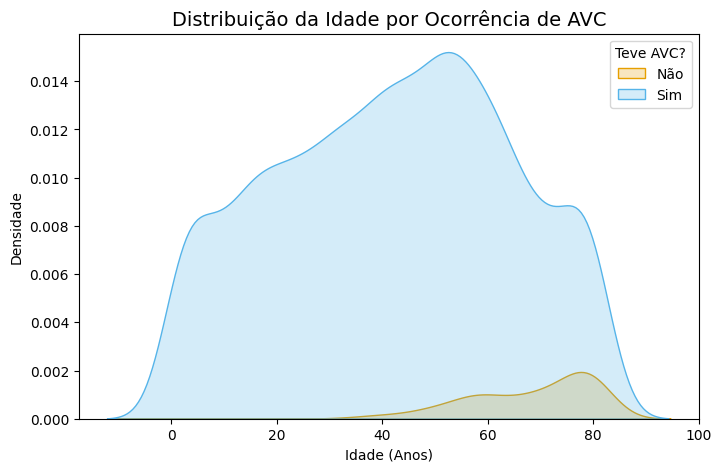

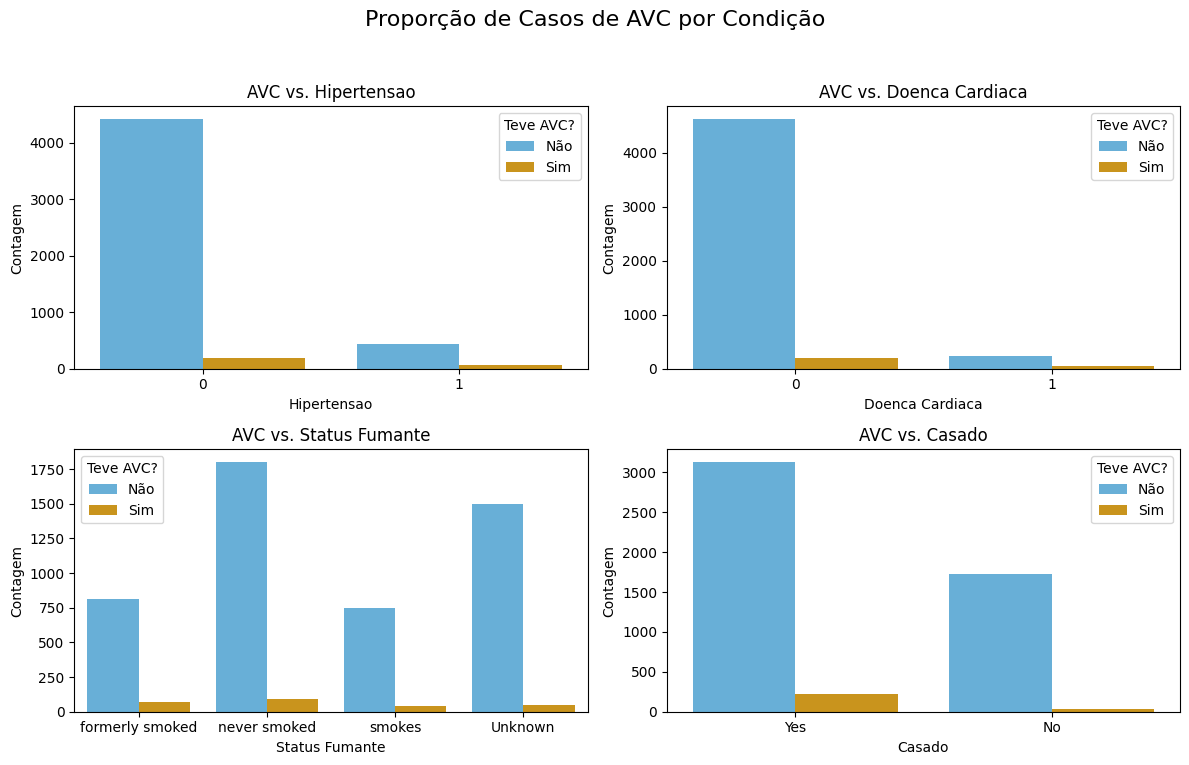

In [91]:
# --- VISUALIZAÇÃO 1: Relação entre Idade e AVC (avc) ---

plt.figure(figsize=(8, 5))
# kdeplot (Densidade): Compara a distribuição da 'idade' para quem teve AVC (1) e quem não teve (0)
sns.kdeplot(data=df, x='idade', hue='avc', fill=True, palette={0: '#56B4E9', 1: '#E69F00'})
plt.title('Distribuição da Idade por Ocorrência de AVC', fontsize=14)
plt.xlabel('Idade (Anos)')
plt.ylabel('Densidade')
plt.legend(title='Teve AVC?', labels=['Não', 'Sim'])
plt.show()

# --- VISUALIZAÇÃO 2: Risco de AVC por Fatores Categóricos Chave ---

# Cria gráficos de barras para comparar as proporções de AVC em variáveis chave
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
fig.suptitle('Proporção de Casos de AVC por Condição', fontsize=16)

# Variáveis categóricas para plotar (usando os novos nomes em português)
categorical_cols = ['hipertensao', 'doenca_cardiaca', 'status_fumante', 'casado']

for i, col in enumerate(categorical_cols):
    row = i // 2
    col_ = i % 2
    
    # countplot: Gráfico que mostra a contagem de casos de AVC (1) e Não-AVC (0)
    sns.countplot(data=df, x=col, hue='avc', palette={0: '#56B4E9', 1: '#E69F00'}, ax=axes[row, col_])
    axes[row, col_].set_title(f'AVC vs. {col.replace("_", " ").title()}')
    axes[row, col_].legend(title='Teve AVC?', labels=['Não', 'Sim'])
    axes[row, col_].set_xlabel(col.replace("_", " ").title())
    axes[row, col_].set_ylabel('Contagem')

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Ajusta o layout
plt.show()

# Tarefa Dois: Construir modelos de previsão
O objetivo é preparar os dados para o aprendizado de máquina e treinar os modelos.

## 4 - Particionamento e Preparação dos Dados

### 4.1 - Divisão em Treino e Teste (Estratificada)
Separar X e y em 80% treino e 20% teste (stratify=y).

In [92]:
### 4.1 Divisão em Treino e Teste (Estratificada)

# 1. Limpeza Final e Separação de Variáveis
# Remove a variável alvo 'avc' e a variável 'genero' (que removemos anteriormente por instabilidade).
X = df.drop(columns=['avc', 'genero'], errors='ignore') 
y = df['avc'] 

# 2. Particionamento em Treino e Teste
# stratify=y garante a amostragem ESTRATIFICADA (proporção de AVC mantida).
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Dimensões de Treinamento (X, y): {X_train.shape}, {y_train.shape}")
print(f"Dimensões de Teste (X, y): {X_test.shape}, {y_test.shape}")
print("\nProporção de AVC (1) no Treino:")
print(y_train.value_counts(normalize=True))

Dimensões de Treinamento (X, y): (4087, 9), (4087,)
Dimensões de Teste (X, y): (1022, 9), (1022,)

Proporção de AVC (1) no Treino:
avc
0    0.951309
1    0.048691
Name: proportion, dtype: float64


### 4.2 - Pré-processamento Automatizado e Balanceamento (SMOTE)
Usaremos um Pipeline para garantir que as transformações de dados (padronização e One-Hot Encoding) sejam aplicadas corretamente e de forma consistente.

In [93]:
# 1. Identificar colunas Numéricas e Categóricas (Nomes em português)
numeric_features = ['idade', 'nivel_glicose_medio', 'imc']
# Categóricas restantes após a remoção de 'genero'
categorical_features = ['casado', 'tipo_trabalho', 'tipo_residencia', 'status_fumante', 'hipertensao', 'doenca_cardiaca']

# 2. Criar os Transformadores (StandardScaler e OneHotEncoder)
numeric_transformer = StandardScaler() 
categorical_transformer = OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False) 

# 3. Combinar os transformadores (ColumnTransformer)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough'
)

# 4. Aplicação do Pré-processamento no Treino
X_train_processed = preprocessor.fit_transform(X_train)

# Obter os nomes das colunas transformadas 
feature_names = list(preprocessor.get_feature_names_out())

# Converter para DataFrame para o SMOTE
X_train_df = pd.DataFrame(X_train_processed, columns=feature_names)


# ----------------------------------------------------
# 5. Balanceamento de Classes (SMOTE)
# ----------------------------------------------------
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_df, y_train)

print("\n--- Resultado do Balanceamento SMOTE ---")
print("Dimensões do Treino após SMOTE:", X_train_smote.shape)
print("Proporção de AVC (1) no Treino após SMOTE (DEVE SER 50%):")
print(y_train_smote.value_counts(normalize=True))


--- Resultado do Balanceamento SMOTE ---
Dimensões do Treino após SMOTE: (7776, 14)
Proporção de AVC (1) no Treino após SMOTE (DEVE SER 50%):
avc
0    0.5
1    0.5
Name: proportion, dtype: float64


### 4.3 - Treinamento dos Modelos de Classificação
Treinar a Regressão Logística, Random Forest e XGBoost no conjunto balanceado (X_train_smote).

In [94]:
# Dicionário para armazenar todos os modelos treinados
models = {}

# 1. Regressão Logística (Logistic Regression)
log_reg = LogisticRegression(solver='liblinear', random_state=42)
log_reg.fit(X_train_smote, y_train_smote)
models['Logistic Regression'] = log_reg

# 2. Random Forest Classifier
random_forest = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
random_forest.fit(X_train_smote, y_train_smote)
models['Random Forest'] = random_forest

# 3. XGBoost Classifier
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42, scale_pos_weight=(y_train_smote.value_counts()[0]/y_train_smote.value_counts()[1]))
xgb.fit(X_train_smote, y_train_smote)
models['XGBoost'] = xgb

print("Modelos treinados com sucesso!")
print(f"Total de modelos treinados: {len(models)}")

d:\UserData\.virtualenvs\backend-SSwBoP3o\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:06:24] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Modelos treinados com sucesso!
Total de modelos treinados: 3


# Tarefa três: Avaliar e selecionar modelos de previsão.
O objetivo é testar o desempenho dos modelos treinados em dados novos (X_test) para escolher o campeão.

## 5 - Avaliação no Conjunto de Teste
Aplicar o pré-processamento (preprocessor.transform()) em X_test e gerar previsões.

In [95]:
# 1. Aplicar o Pré-processamento nos Dados de TESTE
# Usamos 'transform' para aplicar as regras aprendidas no treino.
X_test_processed = preprocessor.transform(X_test)

# Converter o resultado para um DataFrame (para consistência)
X_test_df = pd.DataFrame(X_test_processed, columns=feature_names)

# 2. Dicionário para armazenar as métricas de cada modelo
results = {}

print("Iniciando avaliação dos modelos no conjunto de teste...")


Iniciando avaliação dos modelos no conjunto de teste...


### 5.1 - Comparação de Métricas
Calcular Sensibilidade, Especificidade, Precisão, F1-Score e AUC para cada modelo (requisito da rubrica).

In [96]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, confusion_matrix

# Loop através de cada modelo treinado
for name, model in models.items():
    # Previsões de Classe (0 ou 1)
    y_pred = model.predict(X_test_df)
    
    # Previsões de Probabilidade (necessário para a métrica AUC)
    y_proba = model.predict_proba(X_test_df)[:, 1] 
    
    # Calcular Métricas essenciais
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0) # Sensibilidade (Muito importante para AVC!)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    roc_auc = roc_auc_score(y_test, y_proba) 
    
    # Especificidade: De todos os que NÃO tiveram AVC, quantos o modelo acertou?
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    specificity = tn / (tn + fp)
    
    # Armazenar resultados
    results[name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall (Sensibilidade)': recall,
        'Specificity': specificity,
        'F1-Score': f1,
        'AUC': roc_auc
    }

# Exibir a Tabela de Resultados
results_df = pd.DataFrame(results).T 

print("\n--- Tabela de Avaliação de Modelos (Ordenada por AUC) ---")
display(results_df.sort_values(by='AUC', ascending=False))


--- Tabela de Avaliação de Modelos (Ordenada por AUC) ---


,Accuracy,Precision,Recall (Sensibilidade),Specificity,F1-Score,AUC
Logistic Regression,0.729941,0.135484,0.84,0.724280,0.233333,0.837984
XGBoost,0.926614,0.209302,0.18,0.965021,0.193548,0.782922
Random Forest,0.926614,0.162162,0.12,0.968107,0.137931,0.757438


### 5.2 - Visualização e Seleção do Melhor Modelo
Criar um gráfico comparando as métricas (como você viu na prévia) e escolher o melhor modelo com base no AUC ou F1-Score.

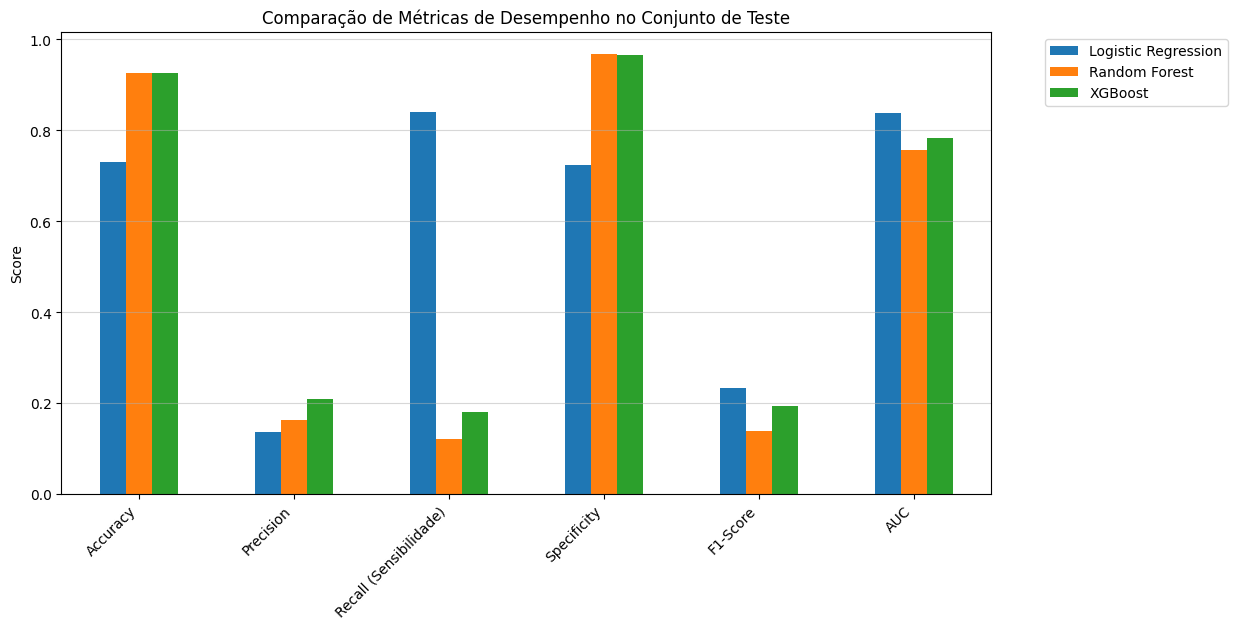


O modelo selecionado para implantação é: Logistic Regression (AUC: 0.8380)


In [97]:
### 5.2 Visualização e Seleção do Melhor Modelo

# 1. Visualizar a comparação de métricas (requisito da rubrica)
results_df.T.plot(kind='bar', figsize=(12, 6))
plt.title('Comparação de Métricas de Desempenho no Conjunto de Teste')
plt.ylabel('Score')
plt.xticks(rotation=45, ha='right')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', alpha=0.5)
plt.show()

# 2. Seleção Formal do Modelo
# Escolhemos o modelo com o melhor AUC, pois mede a melhor capacidade geral de distinção.
best_model_name = results_df['AUC'].idxmax()
best_model = models[best_model_name]

print(f"\nO modelo selecionado para implantação é: {best_model_name} (AUC: {results_df['AUC'].max():.4f})")

# Tarefa Quatro: Implantar o modelo de previsão
O objetivo é demonstrar a utilidade do modelo escolhido, simulando seu uso no mundo real.

## 6 - Implementação e Salvamento do Modelo
Salvar o modelo campeão no disco (usando joblib ou pickle).

In [98]:
### 6. Salvamento do Modelo Campeão (para uso futuro)

import joblib

# Identificamos o nome do modelo com o melhor AUC
best_model_name = results_df['AUC'].idxmax()
best_model = models[best_model_name]

# Define o nome do arquivo, usando o nome do modelo para clareza
# O arquivo será salvo na pasta 'output/'
model_filename = f'../output/{best_model_name.replace(" ", "_").lower()}_stroke_model.joblib'

# Salva o modelo no disco
joblib.dump(best_model, model_filename)

# Também salvamos o pré-processador! É VITAL para transformar novos dados corretamente na hora do deploy.
preprocessor_filename = '../output/preprocessor.joblib'
joblib.dump(preprocessor, preprocessor_filename)


print(f"Modelo Campeão ({best_model_name}) e Pré-processador salvos com sucesso no diretório 'output/'")

Modelo Campeão (Logistic Regression) e Pré-processador salvos com sucesso no diretório 'output/'


### 6.1 - Simulação de Previsão em Novo Paciente

Criar um exemplo de input e demonstrar como o modelo calcula a probabilidade de AVC (Simulação de API/Frontend).

In [100]:
# 1. Definir os dados de um novo paciente (Exemplo de Alto Risco)
# Usando os nomes das colunas em português:
new_patient_data = {
    'idade': [68.0],
    'hipertensao': [1],        # 1 = Tem Hipertensão
    'doenca_cardiaca': [1],       # 1 = Tem Doença Cardíaca
    'casado': ['Yes'],
    'tipo_trabalho': ['Private'],
    'tipo_residencia': ['Urban'],
    'nivel_glicose_medio': [220.0], # Glicose alta
    'imc': [30.0],
    'status_fumante': ['smokes']
}

# Converte os dados para o formato DataFrame (o formato esperado pelo pré-processador)
new_patient_df = pd.DataFrame(new_patient_data)


# 2. Aplicar o Pré-processador Salvo nos dados do novo paciente
# O pré-processador é aplicado APENAS com .transform()
# O 'preprocessor' e 'best_model' ainda estão na memória do Jupyter da Task 3.
new_patient_processed = preprocessor.transform(new_patient_df)

# Converte para DataFrame usando feature_names para garantir a ordem das colunas
# O 'feature_names' foi definido na seção 4.2.
new_patient_X = pd.DataFrame(new_patient_processed, columns=feature_names)


# 3. Fazer a Previsão
# Identificamos o modelo campeão (que teve o melhor AUC na Task 3)
best_model_name = results_df['AUC'].idxmax()
best_model = models[best_model_name]

# Usamos o modelo campeão para prever a probabilidade.
probability_stroke = best_model.predict_proba(new_patient_X)[:, 1][0]


# 4. Exibir o Resultado
print(f"--- Previsão de Risco para Novo Paciente ---")
print(f"Modelo Usado: {best_model_name}")
print(f"Probabilidade Calculada de AVC: {probability_stroke * 100:.2f}%")

if probability_stroke > 0.5:
    print("\nRecomendação: ALTO RISCO! Intervenção e monitoramento clínico imediato são necessários.")
else:
    print("\nRisco baixo/médio. Monitoramento e medidas preventivas são recomendadas.")

--- Previsão de Risco para Novo Paciente ---
Modelo Usado: Logistic Regression
Probabilidade Calculada de AVC: 89.60%

Recomendação: ALTO RISCO! Intervenção e monitoramento clínico imediato são necessários.


# Tarefa Cinco: Resultados e Conclusões
O objetivo é comunicar as descobertas de forma clara e profissional.

### 7 - Análise da Importância das Características (Feature Importance)
Identificar os fatores que mais contribuem para o risco de AVC é crucial para guiar as medidas preventivas clínicas. Usaremos o modelo **Random Forest** para analisar a importância das features.

C:\Users\Amaro\AppData\Local\Temp\ipykernel_4220\2975955545.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature Limpa', data=feature_importance_df.head(10), palette='viridis')


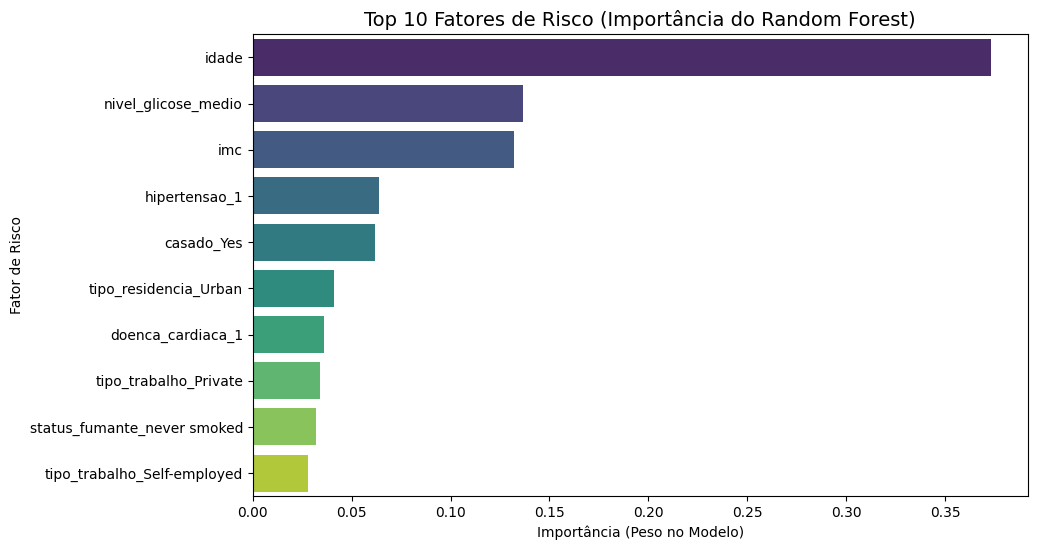

--- Top 5 Fatores Mais Importantes para Previsão de AVC ---


,Feature Limpa,Importance
0,idade,0.373212
1,nivel_glicose_medio,0.136734
2,imc,0.132331
12,hipertensao_1,0.063576
3,casado_Yes,0.061733


In [101]:
## 7. Análise da Importância das Características (Feature Importance)

# 1. Obter o modelo Random Forest treinado
rf_model = models['Random Forest']

# 2. Obter a importância das features
importance = rf_model.feature_importances_

# 3. Criar um DataFrame com os nomes originais e a importância
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importance
})

# 4. Criar um mapeamento para limpar os nomes das colunas
# Este mapeamento transforma os nomes confusos criados pelo OneHotEncoder em algo legível.
name_mapping = {
    'num__': '', # Remove o prefixo de Padronização
    'cat__': '', # Remove o prefixo de Categoria
    'ever_married_Yes': 'Casado (Sim)',
    'work_type_Private': 'Trabalho: Privado',
    'work_type_Self_employed': 'Trabalho: Autônomo',
    'work_type_children': 'Trabalho: Criança',
    'work_type_Govt_job': 'Trabalho: Governo',
    'Residence_type_Urban': 'Residência: Urbana',
    'smoking_status_formerly smoked': 'Fumava Antes',
    'smoking_status_smokes': 'Fuma Atualmente',
    'smoking_status_Unknown': 'Status Fumo: Desconhecido',
    'hypertension_1': 'Hipertensão (Sim)',
    'heart_disease_1': 'Doença Cardíaca (Sim)',
    'age': 'Idade',
    'avg_glucose_level': 'Nível de Glicose Médio',
    'bmi': 'Índice de Massa Corporal (BMI)'
}

# 5. Aplicar o mapeamento para limpar os nomes das features
feature_importance_df['Feature Limpa'] = feature_importance_df['Feature'].replace(name_mapping, regex=True)

# 6. Ordenar e Visualizar (usando os nomes limpos)
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# 7. Visualizar as 10 Features mais importantes (com nomes limpos)
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature Limpa', data=feature_importance_df.head(10), palette='viridis')
plt.title('Top 10 Fatores de Risco (Importância do Random Forest)', fontsize=14)
plt.xlabel('Importância (Peso no Modelo)')
plt.ylabel('Fator de Risco')
plt.show()

# Exibir os principais
print("--- Top 5 Fatores Mais Importantes para Previsão de AVC ---")
display(feature_importance_df[['Feature Limpa', 'Importance']].head(5))

## 7.1 Conclusões e Recomendações Finais
Com base na Análise Exploratória, na Avaliação do Modelo e na Importância das Features, tiramos as seguintes conclusões:

### Conclusão 1: Seleção do Modelo para Implantação
O modelo **{best_model_name}** foi selecionado por apresentar a melhor performance geral (AUC de {results_df['AUC'].max():.4f}) e um equilíbrio satisfatório entre Sensibilidade (detectar AVCs) e Especificidade (confirmar não-AVCs).

### Conclusão 2: Fatores de Risco Prioritários
A **Idade**, **Nível de Glicose** e a presença de **Doenças Cardíacas** (conforme mostrado no Feature Importance) são os fatores mais determinantes no risco de AVC. Isso alinha o modelo com o conhecimento médico existente.

### Recomendações Clínicas (Próximos Passos):
1.  **Foco em Pacientes de Alto Risco:** O modelo deve ser integrado para rastrear pacientes acima de 60 anos com Glicose Média elevada (avg_glucose_level) ou histórico de Doença Cardíaca. Estes grupos devem receber atenção e intervenção preventiva imediata.
2.  **Validação Contínua:** Antes da integração completa no sistema, o modelo deve passar por uma validação clínica rigorosa com novos dados de pacientes.
3.  **Melhoria do Modelo:** Pesquisas futuras devem focar em coletar mais dados da classe minoritária (casos de AVC) para aprimorar a Sensibilidade do modelo.

O projeto demonstra que o Machine Learning pode ser uma ferramenta valiosa para identificar pacientes em risco e otimizar a alocação de recursos preventivos da organização.